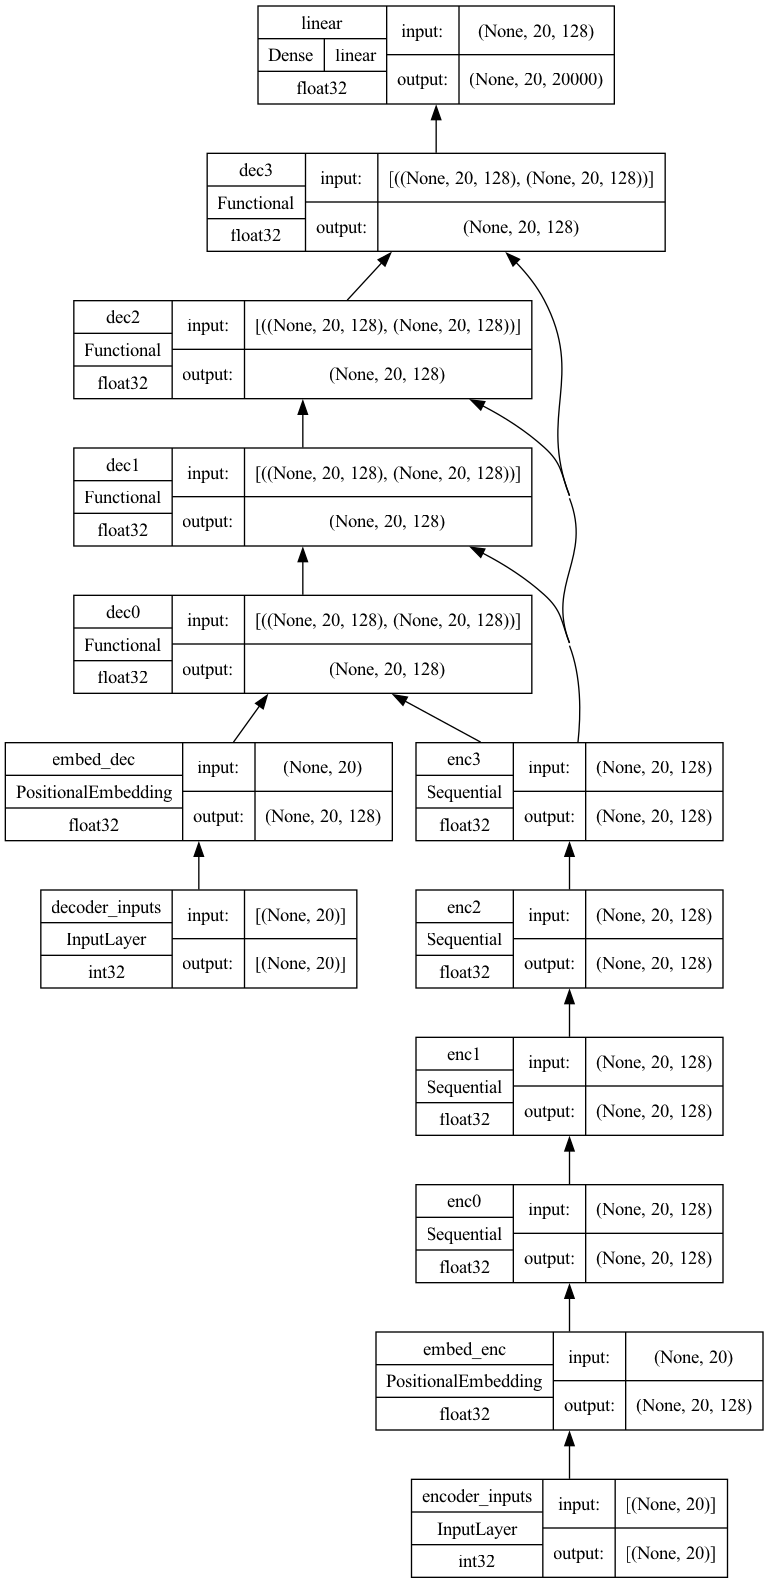

In [2]:
import nbimporter
import tensorflow as tf

from util import PositionalEmbedding
from enc_dec import encoder, decoder

def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src, vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)    # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [
        encoder(input_shape=embed_shape, key_dim=key_dim,
         ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads)
         for i in range(num_layers)
    ]
    decoders = [
        decoder(input_shape=embed_shape, key_dim=key_dim,
         ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads)
         for i in range(num_layers)
    ]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)